In [221]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy

%matplotlib inline

plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200

In [222]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.uInfMag = u_inf
        self.angle = np.deg2rad(alpha)  # degrees --> radians
        self.DragDir = np.array([np.cos(self.angle), np.sin(self.angle)])[np.newaxis,:]
        self.LiftDir = np.array([-np.sin(self.angle), np.cos(self.angle)])[np.newaxis,:]
        self.uv = self.DragDir*self.uInfMag

In [223]:
class FoilBody:
    def __init__(self, xyNodeAll,chordLength,trailingIndicator, scale=1) -> None:
        self.xyNodeAll = xyNodeAll*scale
        self.chordLen = chordLength*scale
        self.numPanel = xyNodeAll.shape[0]-1
        self.trailInd = [i%self.numPanel for i in trailingIndicator]

        self.ConverNodeAlltoAllOthers()

    def ConverNodeAlltoAllOthers(self):
        self.xyNode0 = self.xyNodeAll[:-1]
        self.xyNode1 = self.xyNodeAll[1:]
        self.xyCen = (self.xyNode0+self.xyNode1)/2

        # the tangential and normal direction
        self.xyTang = self.xyNode1 - self.xyNode0
        self.xyNorm = np.vstack((
            -self.xyTang[:,1], self.xyTang[:,0]
        )).T

        # the length
        self.panelLength = np.linalg.norm(self.xyTang, axis=1)
        self.xyTang /= self.panelLength[:,np.newaxis]
        self.xyNorm /= self.panelLength[:,np.newaxis]
        self.xyCen+=self.xyNorm*self.chordLen*0.1*0.01 # an important trick to stablize the system, offset the center a bit outside

    def Translation(self,xy):
        self.xyNodeAll += xy[np.newaxis,:]
        self.ConverNodeAlltoAllOthers()
        return self

    def MirrorY(self):
        self.xyNodeAll = np.flip(self.xyNodeAll, axis=0)
        self.xyNodeAll[:,0] = -self.xyNodeAll[:,0]
        self.ConverNodeAlltoAllOthers()
        return self
    
    def MirrorX(self):
        self.xyNodeAll = np.flip(self.xyNodeAll, axis=0)
        self.xyNodeAll[:,1] = -self.xyNodeAll[:,1]
        self.ConverNodeAlltoAllOthers()
        return self

    def rotate(self,alpha):
        alpha = np.deg2rad(alpha)
        Rot = np.array([
            [np.cos(alpha), -np.sin(alpha)],
            [np.sin(alpha),  np.cos(alpha)]
        ])
        self.xyNodeAll = (Rot@self.xyNodeAll.T).T
        self.ConverNodeAlltoAllOthers()
        return self

In [224]:
def PlotFoilVector(foils,xmin, xmax, ymin, ymax):
    fig,ax = plt.subplots(figsize=(13,4))
    for foil in foils:
        plt.quiver(foil.xyCen[:,0], foil.xyCen[:,1], foil.xyTang[:,0]*foil.panelLength, foil.xyTang[:,1]*foil.panelLength, scale_units='xy', angles='xy', scale=1,width=0.001)
        plt.quiver(foil.xyCen[:,0], foil.xyCen[:,1], foil.xyNorm[:,0]*foil.panelLength, foil.xyNorm[:,1]*foil.panelLength, scale_units='xy', angles='xy', scale=1, color="blue",width=0.001)
        plt.scatter(foil.xyCen[foil.trailInd,0],foil.xyCen[foil.trailInd,1],color=["red","darkred"],s=5)
    ax.set_aspect("equal")
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    ax.set_title("Normal and tangential vector of the panel")

In [225]:
def InducedVelocityConstantSource(sigma, Target, Node0, Node1, Tang, Norm):
    eps = 1e-12
    xT = Target[:,np.newaxis,:]
    n0 = Node0[np.newaxis,:,:]
    n1 = Node1[np.newaxis,:,:]
    si = sigma[np.newaxis,:]
    tn = Tang[np.newaxis,:,:]
    nm = Norm[np.newaxis,:,:]
    th = np.arctan2(tn[:,:,1],tn[:,:,0])

    xTn0 = xT-n0
    xTn1 = xT-n1

    xTn0norm = np.linalg.norm(xTn0,axis=2)
    xTn1norm = np.linalg.norm(xTn1,axis=2)

    up = si/(2*np.pi)*(
        np.log(xTn0norm+eps) -
        np.log(xTn1norm+eps)
    )
    up = up[:,:,np.newaxis]*tn

    wp = si/(2*np.pi)*(
        (np.arctan2(xTn1[:,:,1], xTn1[:,:,0])-th)%(2*np.pi) -
        (np.arctan2(xTn0[:,:,1], xTn0[:,:,0])-th)%(2*np.pi)
    )
    wp = wp[:,:,np.newaxis]*nm

    return up+wp

In [226]:
def InducedVelocityConstantVortex(gamma, Target, Node0, Node1, Tang, Norm):
    eps = 1e-12
    xT = Target[:,np.newaxis,:]
    n0 = Node0[np.newaxis,:,:]
    n1 = Node1[np.newaxis,:,:]
    ga = gamma[np.newaxis,:]
    tn = Tang[np.newaxis,:,:]
    nm = Norm[np.newaxis,:,:]
    th = np.arctan2(tn[:,:,1],tn[:,:,0])

    xTn0 = xT-n0
    xTn1 = xT-n1

    xTn0norm = np.linalg.norm(xTn0,axis=2)
    xTn1norm = np.linalg.norm(xTn1,axis=2)

    up = ga/(2*np.pi)*(
        (np.arctan2(xTn1[:,:,1], xTn1[:,:,0])-th)%(2*np.pi) -
        (np.arctan2(xTn0[:,:,1], xTn0[:,:,0])-th)%(2*np.pi)
    )
    up = up[:,:,np.newaxis]*tn

    wp = -ga/(2*np.pi)*(
        np.log(xTn0norm+eps) -
        np.log(xTn1norm+eps)
    )
    wp = wp[:,:,np.newaxis]*nm

    return up+wp

In [227]:
def SolveStrength(foils: list[FoilBody], stream: Freestream):
    numFoil = len(foils)
    uCenSource = np.empty((numFoil,numFoil),dtype=np.ndarray)
    uCenVortex = np.empty((numFoil,numFoil),dtype=np.ndarray)
    ASourceN = np.empty((numFoil,numFoil),dtype=np.ndarray)
    ASourceT = np.empty((numFoil,numFoil),dtype=np.ndarray)
    AVortexN = np.empty((numFoil,numFoil),dtype=np.ndarray)
    AVortexT = np.empty((numFoil,numFoil),dtype=np.ndarray)
    bSourceN = np.empty((numFoil,),dtype=np.ndarray)
    bVortexT = np.empty((numFoil,),dtype=np.ndarray)
    AblockElement = np.empty((numFoil,numFoil),dtype=np.ndarray)
    bblockElement = np.empty((numFoil,),dtype=np.ndarray)
    numPanelList = np.zeros(numFoil, dtype=int)
    
    for iFoilTarget, foilTarget in enumerate(foils):
        for iFoilSource, foilSource in enumerate(foils):
            uCenSource[iFoilTarget][iFoilSource] = InducedVelocityConstantSource(np.ones(foilSource.numPanel), foilTarget.xyCen, foilSource.xyNode0, foilSource.xyNode1, foilSource.xyTang, foilSource.xyNorm)
            uCenVortex[iFoilTarget][iFoilSource] = InducedVelocityConstantVortex(np.ones(foilSource.numPanel), foilTarget.xyCen, foilSource.xyNode0, foilSource.xyNode1, foilSource.xyTang, foilSource.xyNorm)

            ASourceN[iFoilTarget][iFoilSource] = np.einsum('ijk,ik->ij', uCenSource[iFoilTarget][iFoilSource], foilTarget.xyNorm)
            ASourceT[iFoilTarget][iFoilSource] = np.einsum('ijk,ik->ij', uCenSource[iFoilTarget][iFoilSource], foilTarget.xyTang)
            AVortexN[iFoilTarget][iFoilSource] = np.einsum('ijk,ik->ij', uCenVortex[iFoilTarget][iFoilSource], foilTarget.xyNorm)
            AVortexT[iFoilTarget][iFoilSource] = np.einsum('ijk,ik->ij', uCenVortex[iFoilTarget][iFoilSource], foilTarget.xyTang)

            if iFoilTarget==iFoilSource:
                np.fill_diagonal(ASourceN[iFoilTarget][iFoilSource],0.5)
                np.fill_diagonal(ASourceT[iFoilTarget][iFoilSource],0.0)
                np.fill_diagonal(AVortexN[iFoilTarget][iFoilSource],0.0)
                np.fill_diagonal(AVortexT[iFoilTarget][iFoilSource],0.5)

            AblockElement[iFoilTarget][iFoilSource] = np.block([
                [ASourceN[iFoilTarget][iFoilSource], np.sum(AVortexN[iFoilTarget][iFoilSource], axis=1, keepdims=True)],
                [np.sum(ASourceT[iFoilTarget][iFoilSource][foilTarget.trailInd,:],axis=0,keepdims=True),np.sum(AVortexT[iFoilTarget][iFoilSource][foilTarget.trailInd,:],keepdims=True)]
            ])
            # AblockElement[iFoilTarget][iFoilSource] = np.block([
            #     [ASourceN[iFoilTarget][iFoilSource], np.sum(AVortexN[iFoilTarget][iFoilSource], axis=1, keepdims=True)*0],
            #     [np.sum(ASourceT[iFoilTarget][iFoilSource][foilTarget.trailInd,:],axis=0,keepdims=True)*0,1]
            # ])
        bSourceN[iFoilTarget] = -np.einsum('ij,ij->i', foilTarget.xyNorm, stream.uv)
        bVortexT[iFoilTarget] = -np.einsum('ij,ij->i', foilTarget.xyTang, stream.uv)

        bblockElement[iFoilTarget] = np.hstack((
            bSourceN[iFoilTarget], np.sum(bVortexT[iFoilTarget][foilTarget.trailInd])
        ))
        # bblockElement[iFoilTarget] = np.hstack((
        #     bSourceN[iFoilTarget], np.sum(bVortexT[iFoilTarget][foilTarget.trailInd]*0)
        # ))

        numPanelList[iFoilTarget] = foilTarget.numPanel

    endPanelIndex = np.add.accumulate(numPanelList+1)

    AwithLift = np.block(AblockElement.tolist())
    bWithLift = np.hstack(bblockElement.tolist())


    strengthAll = np.linalg.solve(AwithLift,bWithLift)
    strength = np.split(strengthAll,endPanelIndex.tolist())

    for iFoil, foil in enumerate(foils):
        print("The dimensionless flux into FOIL {} is {:.5e}.".format(iFoil, np.sum(strength[iFoil][:-1]*foil.panelLength)/np.sum(foil.panelLength)/stream.uInfMag))

    return uCenSource, uCenVortex, strength

In [228]:
def BoundingBox(foilGroup):
    xyAll = np.vstack([foil.xyCen for foil in foilGroup])
    xmin = np.min(xyAll[:,0])
    xmax = np.max(xyAll[:,0])
    ymin = np.min(xyAll[:,1])
    ymax = np.max(xyAll[:,1])
    xl = xmax-xmin
    yl = ymax-ymin

    padRatiox = 0.2
    padRatioy = 0.5

    xmin -= padRatiox*xl
    xmax += padRatiox*xl
    ymin -= padRatioy*yl
    ymax += padRatioy*yl
    return xmin, xmax, ymin, ymax

In [229]:
def PlotPressureVelocityField(Nx, Ny, xmin, xmax, ymin, ymax, foilGroup, strengths,freestream):
    xMat, yMat = np.meshgrid(np.linspace(xmin,xmax,Nx),np.linspace(ymin,ymax,Ny),indexing="ij")
    xList, yList = xMat.flatten(), yMat.flatten()
    uvPlot = np.zeros((xList.shape[0],2)) + freestream.uv
    for iFoil, foil in enumerate(foilGroup):
        uvPlot += np.sum(
            InducedVelocityConstantSource(strengths[iFoil][:-1], np.vstack((xList,yList)).T, foil.xyNode0, foil.xyNode1, foil.xyTang, foil.xyNorm) +
            InducedVelocityConstantVortex(strengths[iFoil][-1]*np.ones(naca4415.numPanel), np.vstack((xList,yList)).T, foil.xyNode0, foil.xyNode1, foil.xyTang, foil.xyNorm), axis=1
        )

    uPlot = uvPlot[:,0].reshape(xMat.shape)
    vPlot = uvPlot[:,1].reshape(xMat.shape)

    fig,ax = plt.subplots(figsize=(13,4))
    for iFoil, foil in enumerate(foilGroup):
        ax.plot(foil.xyCen[:,0],foil.xyCen[:,1], color="black")
    #ax.plot([0,0.2], [0,0.1], color="black")
    cf = ax.contourf(xMat,yMat,np.sqrt(uPlot**2+vPlot**2), levels=100,cmap="gist_ncar")
    ax.streamplot(xMat.T, yMat.T, uPlot.T, vPlot.T, density=3, linewidth=0.5, color="blue")
    ax.set_aspect("equal")
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    ax.set_title("Velocity Vectors and Pressure Coefficient")
    plt.colorbar(cf,location="bottom")

In [230]:
def PlotProfileonPanel(foilGroup, strength,freestream,uCenSource,uCenVortex):
    velOnPanel = [None]*len(foilGroup)
    presCoeffOnPanel = [None]*len(foilGroup)
    DragCoeff = np.zeros(len(foilGroup))
    LiftCoeff = np.zeros(len(foilGroup))
    for iFoil, foil in enumerate(foilGroup):
        velOnPanel[iFoil] = np.zeros((foil.numPanel, 2))
        for iSourceFoil, sourceFoil in enumerate(foilGroup):
            velOnPanel[iFoil] += np.einsum("ijk,j->ik",uCenSource[iFoil][iSourceFoil],strength[iSourceFoil][:-1]) + np.einsum("ijk,j->ik",uCenVortex[iFoil][iSourceFoil],strength[iSourceFoil][-1]*np.ones(sourceFoil.numPanel))
        velOnPanel[iFoil] += freestream.uv
        presCoeffOnPanel[iFoil] = 1 - (np.linalg.norm(velOnPanel[iFoil], axis=1)/freestream.uInfMag)**2
        ForceCoeff = np.sum(-foil.xyNorm*presCoeffOnPanel[iFoil][:,np.newaxis]*foil.panelLength[:,np.newaxis], axis=0)/foil.chordLen
        DragCoeff[iFoil] = np.dot(ForceCoeff,freestream.DragDir.flatten())
        LiftCoeff[iFoil] = np.dot(ForceCoeff,freestream.LiftDir.flatten())

    fig,ax = plt.subplots(figsize=(13,4))
    for iFoil, foil in enumerate(foilGroup):
        ax.plot(foil.xyCen[:,0],presCoeffOnPanel[iFoil], ".-b")
        ax.plot(foil.xyCen[:,0],-foil.xyCen[:,1]*3, color="black")
    ax.invert_yaxis()
    ax.set_aspect("auto")

    for iFoil, foil in enumerate(foilGroup):
        print("The FOIL {} has Cd = {:.5e} and Cl = {:.5e}.".format(iFoil, DragCoeff[iFoil], LiftCoeff[iFoil]))


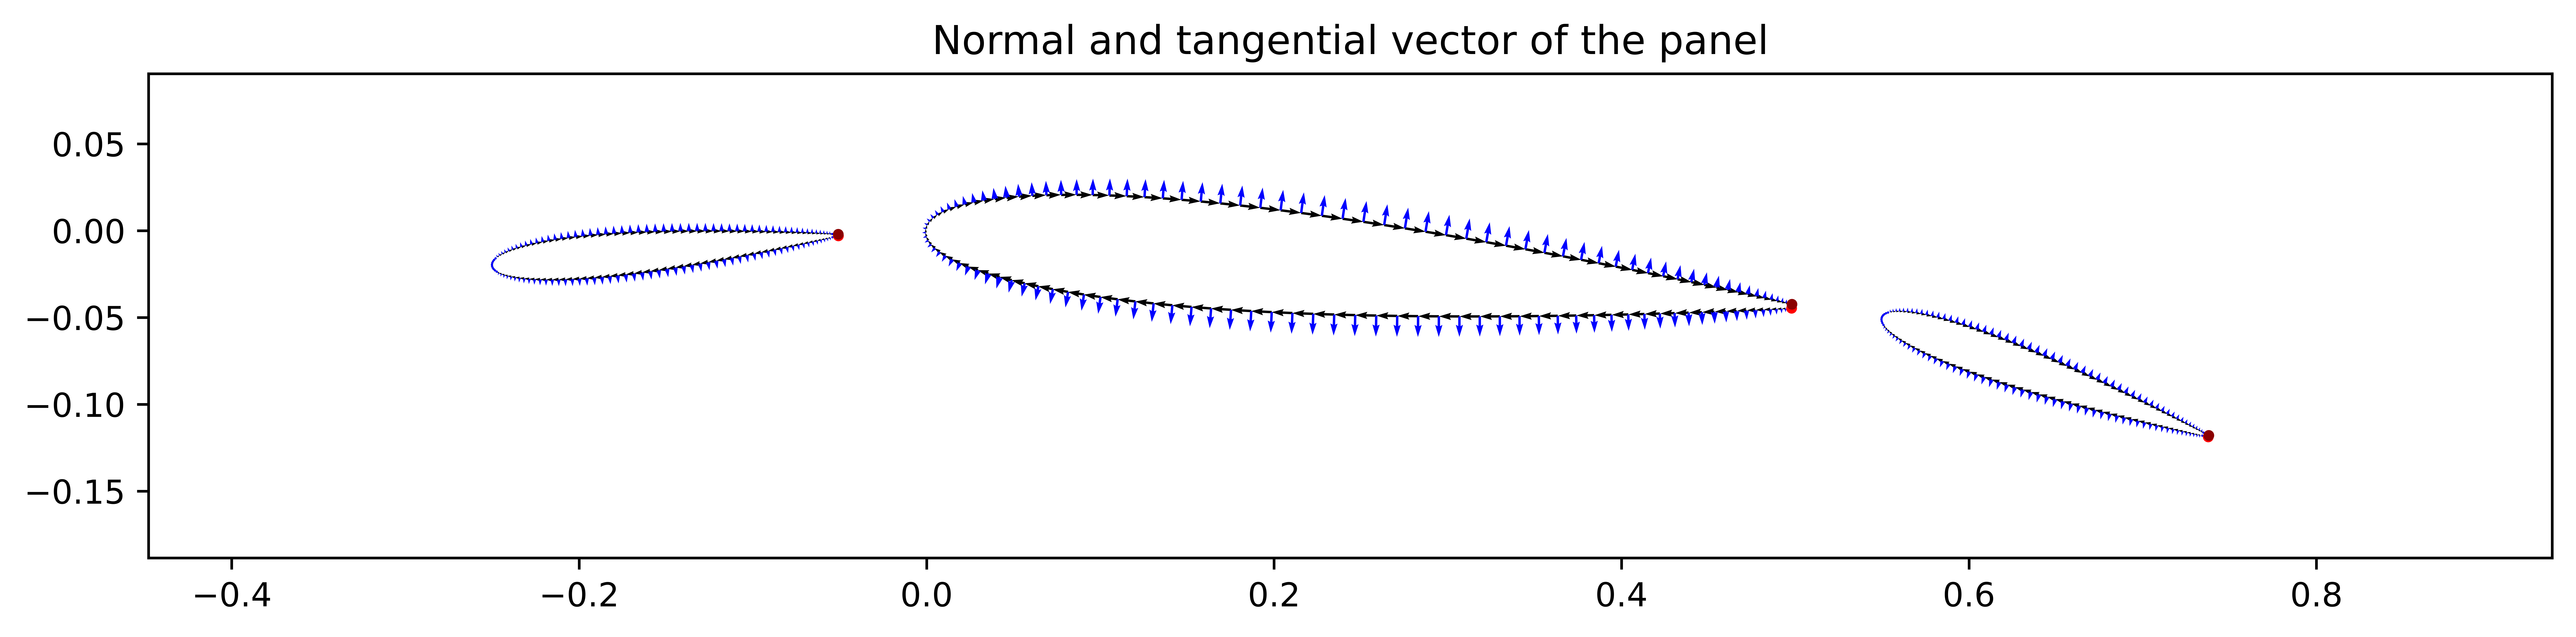

In [231]:
xyNode = np.flip(np.loadtxt("seligNACA0012.txt", skiprows=1),axis=0)
chordLen = 1

naca4415 = FoilBody(xyNode, chordLen, [0,-1], scale=0.5).rotate(-5)
naca4415_2 = FoilBody(xyNode, chordLen, [0,-1], scale=0.2).rotate(-20).Translation(np.array([0.55,-0.05]))
naca4415_3 = FoilBody(xyNode, chordLen, [0,-1], scale=0.2).rotate(5).Translation(np.array([-0.25,-0.02]))

foilGroup = [naca4415,naca4415_2,naca4415_3]
# foilGroup = [naca4415]

xmin, xmax, ymin, ymax = BoundingBox(foilGroup)

PlotFoilVector(foilGroup, xmin, xmax, ymin, ymax)

In [232]:
freestream = Freestream(1,5)
uCenSource, uCenVortex, strength = SolveStrength(foilGroup, freestream)

The dimensionless flux into FOIL 0 is -5.93155e-04.
The dimensionless flux into FOIL 1 is -5.00747e-04.
The dimensionless flux into FOIL 2 is -7.20146e-04.


In [233]:
PlotPressureVelocityField(1000, 1000, xmin, xmax, ymin, ymax, foilGroup, strength, freestream)

In [234]:
PlotProfileonPanel(foilGroup, strength,freestream,uCenSource,uCenVortex)

The FOIL 0 has Cd = 1.00644e-01 and Cl = 1.19771e+00.
The FOIL 1 has Cd = 2.76651e-01 and Cl = 1.14078e+00.
The FOIL 2 has Cd = -1.74319e-01 and Cl = 1.35897e+00.
